In [ ]:
#https://drive.google.com/drive/folders/1JqhpezmmTcm9AfExMHUANcHxvHV_rh0z

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
sns.set_style("darkgrid")
%matplotlib inline
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
import joblib

In [2]:
def train_model(model,train_dataset,batch_size = 10000):        
    print("training start")
    before = 0
    for i in tqdm(range(batch_size,len(train_dataset),batch_size)):
        model.fit(train_dataset[before:i])
        before = i

In [17]:
read_data = pd.read_csv('03_23/VIB_0323_motor_51200.csv', encoding = 'cp949',sep = '\t')

In [18]:
read_data.head(5)

,x1,x2
0,0.382649,-0.306987
1,0.670337,0.194830
2,0.855599,0.254603
3,0.140269,-0.085663
4,0.034768,-0.353546


In [7]:
def get_abnormal_data(dataset,batch_size=5110):
    minv= dataset.iloc[:,1].min()
    maxv = dataset.iloc[:,1].max()
    rng = np.random.RandomState(42)
    before = 0
    train_data = pd.DataFrame([])
    for i in tqdm(range(batch_size,len(dataset),batch_size)):  
        fragment = rng.uniform(low=minv - 10, high=maxv + 10, size=batch_size),
        fragment = pd.DataFrame(fragment)
        before = i
        train_data = train_data.append(fragment,ignore_index=True)
        
    return train_data

In [8]:
def data_process(data_frame,batch_size=5110):
    before = 0
    train_data = pd.DataFrame([[]])
    for i in tqdm(range(batch_size,len(data_frame),batch_size)):
        features = pd.DataFrame(get_features(data_frame[before:i]),
                                columns = ['mean','std','min','first_quartile','median','third_quartile','max'])
        before = i
        train_data = train_data.append(features,ignore_index=True)
        
    return train_data[1:]

In [9]:
def get_features(train_data):
    describe = train_data.describe(include='all')
    mean = describe.loc['mean']
    std = describe.loc['std'] #표준편차,
    min = describe.loc['min'] 
    first_quartile= describe.loc['25%']
    median = describe.loc['50%']
    third_quartile = describe.loc['75%']
    max = describe.loc['max'] 
    
    return [[mean,std,min,first_quartile,median,third_quartile,max]]

In [10]:
def pca(train_data,dimension = 2):
    pca = PCA(n_components=dimension)
    printcipalComponents = pca.fit_transform(train_data)
    principalDf = pd.DataFrame(data=printcipalComponents, columns = ['x1', 'x2'])
    return principalDf

In [11]:
def scaling(dataset,scaler = preprocessing.MaxAbsScaler()):
    return scaler.fit_transform(dataset)

In [12]:
def save_model(clf,filepath):
    # 확장자명 .pkl
    joblib.dump(clf, filepath) 

In [13]:
def load_model(filepath):
    return joblib.load(filepath) 

In [14]:
def get_anomaly_scores(clf,data):
    return clf.decision_function(data).reshape(-1,1)

In [15]:
def get_abnormal_data(dataset,batch_size=5110):
    minv= dataset.iloc[:,1].min()
    maxv = dataset.iloc[:,1].max()
    rng = np.random.RandomState(42)
    before = 0
    train_data = pd.DataFrame([])
    for i in tqdm(range(batch_size,len(dataset),batch_size)):  
        fragment = rng.uniform(low=minv - 10, high=maxv + 10, size=batch_size),
        fragment = pd.DataFrame(fragment)
        before = i
        train_data = train_data.append(fragment,ignore_index=True)
        
    return train_data

In [16]:
train_data = data_process(read_data.iloc[:47960000,1])

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 427.54it/s]


In [15]:
principalDf = pca(train_data)

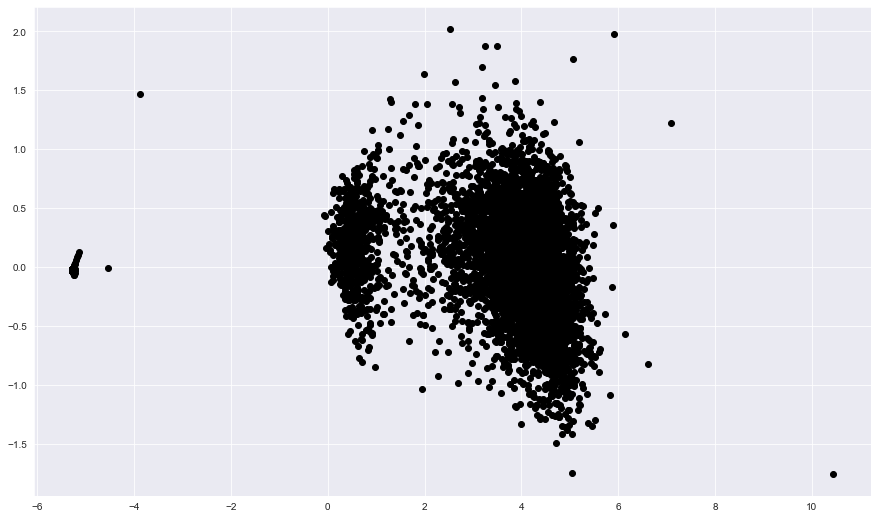

In [16]:
fig = plt.figure(figsize=(15, 9))
# ax = fig.add_subplot(111, projection='3d')

plt.scatter(principalDf['x1'], principalDf['x2'], color = 'black', label = 'pca')

In [17]:
train = principalDf

In [109]:
valid_set = pd.read_csv('03_24/VIB_0324_motor_51200.csv', encoding = 'cp949',sep = '\t')

In [110]:
valid = data_process(valid_set.iloc[:47960000,1])
valid = pca(valid)

100%|█████████████████████████████████████████████████████████████████████████████| 9385/9385 [00:17<00:00, 524.08it/s]


In [20]:
abnormal_set = pd.read_csv('motor_abnormal.csv',encoding='cp949')

In [21]:
abnormal_data = abnormal_set.to_numpy().reshape(-1)

In [22]:
abnormal_data = pd.DataFrame(abnormal_data)

In [23]:
abnormal = data_process(abnormal_data)

100%|███████████████████████████████████████████████████████████████████████████| 13905/13905 [00:57<00:00, 239.78it/s]


In [24]:
abnormal = pca(abnormal)

In [111]:
#scaling
min_max_scaler = preprocessing.MinMaxScaler()
scaled_train = min_max_scaler.fit_transform(train)
scaled_valid = min_max_scaler.fit_transform(valid)
scaled_abnormal = min_max_scaler.fit_transform(abnormal)

#standard_scaler = preprocessing.StandardScaler()
# scaled_train = standard_scaler.fit_transform(train)
# scaled_valid = standard_scaler.fit_transform(valid)

# max_abs_scaler = preprocessing.MaxAbsScaler()
# scaled_train = scaling(train,max_abs_scaler)
# scaled_valid = scaling(valid,max_abs_scaler)
# scaled_abnormal = scaling(abnormal,max_abs_scaler)

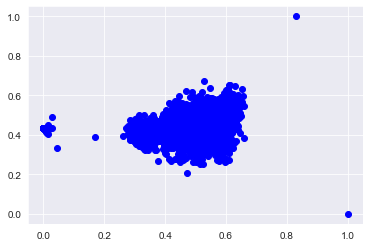

In [112]:
plt.scatter(scaled_valid[:,0], scaled_valid[:,1], color = 'blue', label = 'normal')

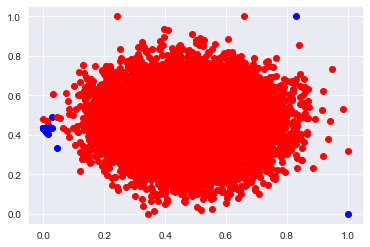

In [113]:
plt.scatter(scaled_valid[:,0], scaled_valid[:,1], color = 'blue', label = 'normal')
#plt.scatter(X_outliers.iloc[:,0], X_outliers.iloc[:,1], color = 'red', label = 'abnormal')
plt.scatter(scaled_abnormal[:,0], scaled_abnormal[:,1], color = 'red', label = 'abnormal')
plt.show()

In [131]:
from sklearn.neighbors import LocalOutlierFactor
#clf = IsolationForest(max_samples=10, contamination = 0.1, random_state=42)
clf = LocalOutlierFactor(n_neighbors=1000,novelty=True)

In [123]:
#train_model(clf,scaled_valid,batch_size = 1000)      

training start


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.27it/s]


In [132]:
clf.fit(scaled_train)

LocalOutlierFactor(n_neighbors=1000, novelty=True)

In [133]:
anomaly_scores = get_anomaly_scores(clf,scaled_valid)

In [134]:
outliers = get_anomaly_scores(clf,abnormal)

In [135]:
anomaly_scores = pd.DataFrame(anomaly_scores.reshape(-1) ,columns=['x1'])

In [136]:
outliers = pd.DataFrame(outliers.reshape(-1) ,columns=['x1'])

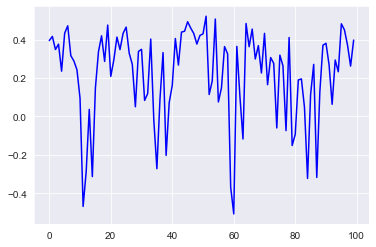

In [137]:
plt.plot(anomaly_scores[:100].index,
         anomaly_scores[:100],
          color='blue', label="normal")

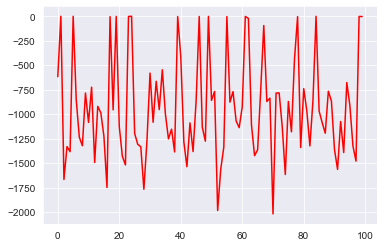

In [138]:
plt.plot(outliers[:100].index,
         outliers[:100],
          color='red', label="anomaly")


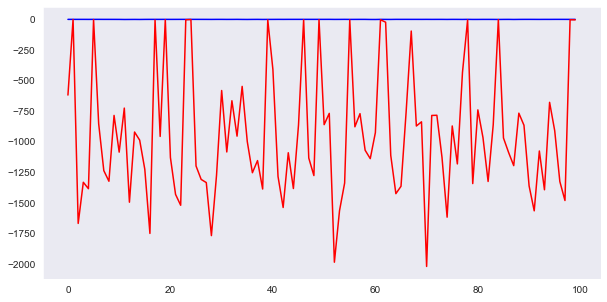

In [139]:
plt.figure(figsize=(10,5))

plt.plot(anomaly_scores[:100].index,
         anomaly_scores[:100],
          color='blue', label="normal")

plt.plot(outliers[:100].index,
         outliers[:100],
          color='red', label="anomaly")


plt.grid()

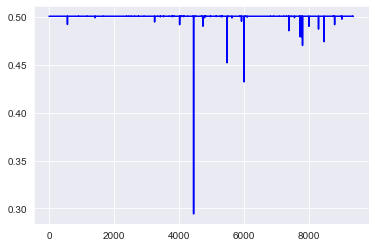

In [36]:
plt.plot(anomaly_scores.index,
         anomaly_scores,
          color='blue', label="normal")

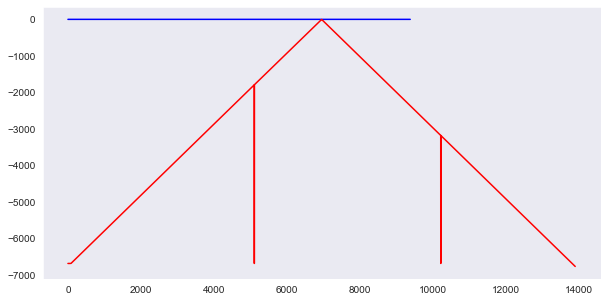

In [37]:
plt.figure(figsize=(10,5))

plt.plot(anomaly_scores.index,
         anomaly_scores,
          color='blue', label="normal")

plt.plot(outliers.index,
         outliers,
          color='red', label="anomaly")


plt.grid()

In [191]:
joblib.dump(clf, 'IF_Model_20220408_motor_minmax_2feature_v1.pkl') 

['IF_Model_20220408_motor_minmax_2feature_v1.pkl']

In [57]:
joblib.dump(min_max_scaler, 'IF_MinMaxScaler_20220406_pump_minmax_v1.pkl') 

['IF_MinMaxScaler_20220406_motor_minmax_v1.pkl']

In [195]:
clf = joblib.load('IF_Model_20220408_motor_minmax_2feature_v1.pkl')